# EARIN - Breast cancer predictors 
1. The aim of this script is to predict whether the cancer is benign or malignant
2. Three main estimators built with a given learning algorithm were used
    - RandomForestClassifier
    - GradientBoostingClassifier
    - BoostingClassifier
3. Data source: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data 

In [55]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from sklearn.tree import export_graphviz, DecisionTreeClassifier

from sklearn.tree import export_graphviz, DecisionTreeClassifier

In [56]:
def run_kfold(model, data, predictors, outcome):
    kf = KFold(n_splits=5)
    outcomes = []
    error = []
    fold = 0
    for  train, test in kf.split(data):
      train_predictors = (data[predictors].iloc[train,:])
      train_target = data[outcome].iloc[train]
      model.fit(train_predictors, train_target)
      error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
      print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))
      model.fit(data[predictors],data[outcome]) 

# Data exploration
Below there is presented data contents. From diagnosis plot it is observed that there are more benign diagnosis. Also there is comparison of each single features and how they are distributed in order ofdiagnosis. 

In [57]:
data = pd.read_csv('data.csv')

data.drop('id', axis=1,inplace=True)
data.sample(5)
#data.diagnosis.unique()


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
270,B,14.29,16.82,90.30,632.6,0.06429,0.02675,0.00725,0.00625,0.1508,...,14.91,20.65,94.44,684.6,0.08567,0.05036,0.03866,0.03333,0.2458,0.06120
541,B,14.47,24.99,95.81,656.4,0.08837,0.12300,0.10090,0.03890,0.1872,...,16.22,31.73,113.50,808.9,0.13400,0.42020,0.40400,0.12050,0.3187,0.10230
131,M,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,...,19.26,26.00,124.90,1156.0,0.15460,0.23940,0.37910,0.15140,0.2837,0.08019
174,B,10.66,15.15,67.49,349.6,0.08792,0.04302,0.00000,0.00000,0.1928,...,11.54,19.20,73.20,408.3,0.10760,0.06791,0.00000,0.00000,0.2710,0.06164
380,B,11.27,12.96,73.16,386.3,0.12370,0.11110,0.07900,0.05550,0.2018,...,12.84,20.53,84.93,476.1,0.16100,0.24290,0.22470,0.13180,0.3343,0.09215


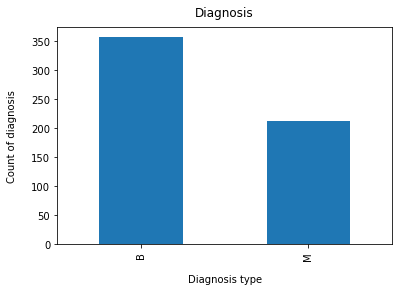

In [58]:
data['diagnosis'].value_counts().plot(kind='bar')
plt.xlabel("Diagnosis type", labelpad=14)
plt.ylabel("Count of diagnosis", labelpad=14)
plt.title("Diagnosis", y=1.02)
plt.show()


0.42257999999999996
0.5914
2.8942
47.15
0.0022153999999999997
0.006520399999999999
0.008536
0.004024
0.00396
0.0009495999999999999


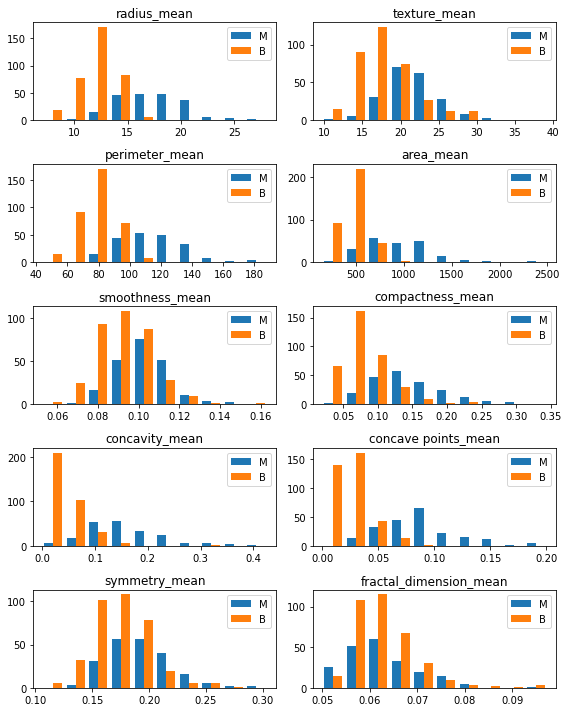

In [59]:
features_mean=list(data.columns[1:11])
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8,10))
dfM=data[data['diagnosis'] =='M']
dfB=data[data['diagnosis'] =='B']
axes = axes.ravel()
data['diagnosis'] = data['diagnosis'].map({'M':1,'B':0})
for idx,ax in enumerate(axes):
    ax.figure
    binwidth= (max(data[features_mean[idx]]) - min(data[features_mean[idx]]))/50
    print (binwidth)
    ax.hist([dfM[features_mean[idx]],dfB[features_mean[idx]]],label=['M','B'])
    ax.set_title(features_mean[idx])
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Observations 
Following features could be good to predict deasis:
- perimeter
- area
- concave
- radius
- compactness
- concavity


# ROC 
Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

In [60]:
def baseline_score(model, data):
    outcome_var = 'diagnosis'
    predictor_var = ['concave points_mean','area_mean','radius_mean','perimeter_mean','concavity_mean']
    preds_model = model.predict_proba(data[predictor_var])[:,1]
    model_roc_auc = metrics.roc_auc_score(data[outcome_var], preds_model)
    print('The baseline score on the test set is {:.4f}.'.format(model_roc_auc))
    
    return model_roc_auc

# Tested parameters 
The aim of this reasearch is to examine Random Forest, Gradient Boostin or Bagging algorithms in the same specification of trees and compare the results. Two different tree environment was prepared - very poor and more advanced trees. At the end ROC graphs are combined into one graph. 

Parameters of single small tree: 
- The number of trees: 2
- The function to measure the quality of a split: entropy
- The minimum number of samples required to split an internal node: 2
- The maximum depth of single tree: 1
- Complexity parameter used for Minimal Cost-Complexity Pruning: 0.0

Paramters of single big tree: 
- The number of trees: 100
- The function to measure the quality of a split: entropy
- The minimum number of samples required to split an internal node: 2
- The maximum depth of single tree: 10
- Complexity parameter used for Minimal Cost-Complexity Pruning: 0.0

In [61]:
traindf, testdf = train_test_split(data, test_size = 0.3)
predictor_var = ['concave points_mean','area_mean','radius_mean','perimeter_mean','concavity_mean']
model = RandomForestClassifier(n_estimators=2,ccp_alpha = 0.0, criterion = "entropy",min_samples_split=2, max_depth=1, max_features=len(predictor_var))
outcome_var = 'diagnosis'
out = ['1','0']
#run_kfold(model, traindf,predictor_var, outcome_var)


print("Performance on test dataset for poor model")
run_kfold(model, traindf,predictor_var, outcome_var)
rf_1_roc_auc = baseline_score(model,testdf)
rf_1_fpr, rf_1_tpr, rf_1_thresholds = metrics.roc_curve(testdf[outcome_var], model.predict_proba(testdf[predictor_var])[:,1])

#plt.plot(rf_fpr, rf_tpr, label='RF (area = %0.4f)' % rf_roc_auc)
estimator = model.estimators_[0]
export_graphviz(estimator, 
                out_file='RandomForestTree_noprunning.dot', 
                feature_names = predictor_var,
                class_names = out,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

Performance on test dataset for poor model
Cross-Validation Score : 96.250%
Cross-Validation Score : 94.375%
Cross-Validation Score : 93.333%
Cross-Validation Score : 92.468%
Cross-Validation Score : 90.937%
The baseline score on the test set is 0.9027.


# Random Forest Classifier 

In [62]:
model_advanced = RandomForestClassifier(n_estimators=100,ccp_alpha = 0.0, criterion = "entropy",min_samples_split=2, max_depth=10, max_features=5)

print("Performance on test dataset for advanced model")
run_kfold(model_advanced, traindf,predictor_var, outcome_var)
rf_2_roc_auc = baseline_score(model_advanced,testdf)
rf_2_fpr, rf_2_tpr, rf_2_thresholds = metrics.roc_curve(testdf[outcome_var], model_advanced.predict_proba(testdf[predictor_var])[:,1])

estimator = model_advanced.estimators_[0]
export_graphviz(estimator, 
                out_file='RandomForestTree_better.dot', 
                feature_names = predictor_var,
                class_names = out,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

Performance on test dataset for advanced model
Cross-Validation Score : 96.250%
Cross-Validation Score : 94.375%
Cross-Validation Score : 94.167%
Cross-Validation Score : 92.777%
Cross-Validation Score : 91.943%
The baseline score on the test set is 0.9781.


# Gradient Boosting Classifier 


In [63]:
model = GradientBoostingClassifier(ccp_alpha = 0.0,n_estimators=2, min_samples_split=2, max_depth=1, max_features=5)
outcome_var = 'diagnosis'
out = ['1','0']

print("Performance on test dataset")
run_kfold(model, traindf,predictor_var, outcome_var)

gb_roc_auc = baseline_score(model,testdf)
gb_fpr, gb_tpr, gb_thresholds = metrics.roc_curve(testdf[outcome_var], model.predict_proba(testdf[predictor_var])[:,1])


Performance on test dataset
Cross-Validation Score : 68.750%
Cross-Validation Score : 65.000%
Cross-Validation Score : 59.583%
Cross-Validation Score : 60.194%
Cross-Validation Score : 61.320%
The baseline score on the test set is 0.9120.


In [64]:
model_advanced = GradientBoostingClassifier(ccp_alpha = 0.0,n_estimators=100, min_samples_split=2, max_depth=10, max_features=5)
outcome_var = 'diagnosis'
out = ['1','0']

print("Performance on test dataset")
run_kfold(model_advanced, traindf,predictor_var, outcome_var)

gb_2_roc_auc = baseline_score(model_advanced,testdf)
gb_2_fpr, gb_2_tpr, gb_2_thresholds = metrics.roc_curve(testdf[outcome_var], model.predict_proba(testdf[predictor_var])[:,1])


Performance on test dataset
Cross-Validation Score : 95.000%
Cross-Validation Score : 93.125%
Cross-Validation Score : 92.083%
Cross-Validation Score : 91.214%
Cross-Validation Score : 89.680%
The baseline score on the test set is 0.9315.


# Bagging Classifier 

In [65]:
model = BaggingClassifier(n_estimators=2)
outcome_var = 'diagnosis'
out = ['1','0']
print("Performance on test dataset")
run_kfold(model, traindf,predictor_var, outcome_var)
b_roc_auc = baseline_score(model,testdf)
b_fpr, b_tpr, b_thresholds = metrics.roc_curve(testdf[outcome_var], model.predict_proba(testdf[predictor_var])[:,1])




Performance on test dataset
Cross-Validation Score : 95.000%
Cross-Validation Score : 91.875%
Cross-Validation Score : 91.250%
Cross-Validation Score : 90.906%
Cross-Validation Score : 89.180%
The baseline score on the test set is 0.9356.


In [66]:
model_advanced = BaggingClassifier(base_estimator = DecisionTreeClassifier(criterion='entropy', max_depth=10), n_estimators=100)
print("Performance on test dataset")
run_kfold(model_advanced, traindf,predictor_var, outcome_var)
b_2_roc_auc = baseline_score(model_advanced,testdf)
b_2_fpr, b_2_tpr, b_2_thresholds = metrics.roc_curve(testdf[outcome_var], model_advanced.predict_proba(testdf[predictor_var])[:,1])

estimator = model_advanced.estimators_[0]
export_graphviz(estimator, 
                out_file='BaggingClassifier_100.dot', 
                feature_names = predictor_var,
                class_names = out,
                rounded = True, proportion = False, 
                precision = 2, filled = True)


Performance on test dataset
Cross-Validation Score : 95.000%
Cross-Validation Score : 93.750%
Cross-Validation Score : 93.750%
Cross-Validation Score : 92.464%
Cross-Validation Score : 91.693%
The baseline score on the test set is 0.9778.


# Conclusion
Three tested estimators have high perfomance. From the above ROC graph it can be observed that the best estimator is Random Forest Classifier.  

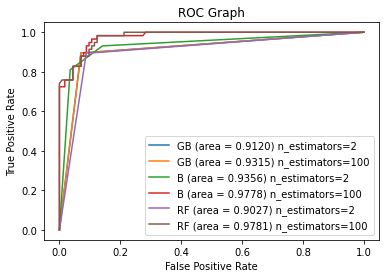

In [67]:
#Plotting
plt.plot(gb_fpr, gb_tpr, label='GB (area = %0.4f) n_estimators=2' % gb_roc_auc)
plt.plot(gb_2_fpr, gb_2_tpr, label='GB (area = %0.4f) n_estimators=100' % gb_2_roc_auc)
plt.plot(b_fpr, b_tpr, label='B (area = %0.4f) n_estimators=2 ' % b_roc_auc)
plt.plot(b_2_fpr, b_2_tpr, label='B (area = %0.4f) n_estimators=100 ' % b_2_roc_auc)
plt.plot(rf_1_fpr, rf_1_tpr, label='RF (area = %0.4f) n_estimators=2' % rf_1_roc_auc)
plt.plot(rf_2_fpr, rf_2_tpr, label='RF (area = %0.4f) n_estimators=100' % rf_2_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()


During this reasearch we examined three the most popular estimators - Random Forest, Gradient Boosting and Bagging. The most accurate is Random Forest classifier. It is said that more number of estimators are picked it may results in better estimation. However, the best one Random Forest is with only one estimator. It is correleted with input data from which we can observe that 'concavity mean' parameter groups straight forward two outcome parameters. But it  should not be the only one and crucial parameter, because it may lead to overtraining of classification model having different dataset. In this case, increasing number of estimators it reduces prediction of classifier, but it gives opportunity to consider others dependencies. So, as a result we can sum up this research that number of estimators should be considered and tested with different values. But we should keep in mind that the more features are considered the more sensitve estimator is. 